In [1]:
# Library
import sys, os
sys.path.append(os.path.abspath('..'))

import hdf5_loader as sc
from myconfig import *
from ts_into_samples import Transforms, StockDatasetIter

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta
import os
import gc
import re
import h5py
import exchange_calendars as xcals
import random
import importlib
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

mi = pd.IndexSlice

In [1]:
_ = importlib.reload()

NameError: name 'importlib' is not defined

In [3]:
def initialize_log_dir(base_log_dir="logs/fit"):
    if os.path.exists(base_log_dir):
        shutil.rmtree(base_log_dir)  # 기존 로그 디렉토리 삭제
    os.makedirs(base_log_dir, exist_ok=True)  # 새 디렉토리 생성
    return os.path.join(base_log_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))

### Model

In [7]:
class SampleModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SampleModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # self.fc = nn.Linear(hidden_size, output_size)
        self.lgl = nn.Sequential(
            torch.nn.Linear(hidden_size, hidden_size*4),
            nn.ReLU(),
            torch.nn.Linear(hidden_size*4, output_size)
        )
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x:torch.Tensor):
        # Initialize hidden and cell states
        # x = x['5m']
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the last time step
        res = self.lgl(out[:, -1, :])
        # res = self.sig(res)
        res = self.tanh(res)
        return res

In [9]:
class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()
        self.CHARGE_RATE = 0.0
        
    def forward(self, predictions, targets):
        charge = torch.abs(predictions) * self.CHARGE_RATE
        return torch.sum((-predictions * targets) + charge) 

In [10]:
hdf5_train = sc.StockDatasetHDF5(
    ticker_list=[
    'AAPL',  # Apple Inc.
    'MSFT',  # Microsoft Corporation
    'GOOGL', # Alphabet Inc. (Google)
    'META',  # Meta Platforms, Inc. (Facebook)
    'IBM',   # International Business Machines Corporation
    'INTC',  # Intel Corporation
    'CSCO',  # Cisco Systems, Inc.
    'ORCL',  # Oracle Corporation
    'HPQ',   # HP Inc.
    'DELL',  # Dell Technologies Inc.
    'QCOM',  # Qualcomm Incorporated
    'TXN',   # Texas Instruments Incorporated
    'ADBE',  # Adobe Inc.
    'NVDA',  # NVIDIA Corporation
    'CRM',   # Salesforce, Inc.
    'PYPL'   # PayPal Holdings, Inc.
],
    date_range=[ST, ED-timedelta(52)]
)
hdf5_valid = sc.StockDatasetHDF5(
    ticker_list=[
    'AAPL',  # Apple Inc.
    'MSFT',  # Microsoft Corporation
    'GOOGL', # Alphabet Inc. (Google)
    'META',  # Meta Platforms, Inc. (Facebook)
    'IBM',   # International Business Machines Corporation
    'INTC',  # Intel Corporation
    'CSCO',  # Cisco Systems, Inc.
    'ORCL',  # Oracle Corporation
    'HPQ',   # HP Inc.
    'DELL',  # Dell Technologies Inc.
    'QCOM',  # Qualcomm Incorporated
    'TXN',   # Texas Instruments Incorporated
    'ADBE',  # Adobe Inc.
    'NVDA',  # NVIDIA Corporation
    'CRM',   # Salesforce, Inc.
    'PYPL'   # PayPal Holdings, Inc.
],
    date_range=[ED-timedelta(weeks=52), ED]
)
hz_window = {k:v for k, v in zip(THZ,
                [1,1,1,100,1])}
hz_patch = {k:5 for k in THZ}
data_min_interval = timedelta(days=100)
label_peroid = 10
label_hz = '1d'
label_density = 1.0
batch_size = 1

dataset = StockDatasetIter(hdf5_train, hz_window, hz_patch, label_peroid, data_min_interval, label_hz, label_density,
                           Transforms.example, Transforms.yexample)
val_dataset = StockDatasetIter(hdf5_valid, hz_window, hz_patch, label_peroid, data_min_interval, label_hz, label_density,
                           Transforms.example, Transforms.yexample)
dataloader = DataLoader(dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 9  # 9 channels
hidden_size = 256
output_size = 1
num_layers = 2
model = SampleModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = MyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [12]:
initial_dir = initialize_log_dir()
record_flag = 2048

# -------------------------------------

epochs = 1

# For recording
outputs_by_epochs = [[] for _ in range(epochs)]

for epoch in range(epochs):
    model.train()  # ------------------
    
    _record_cnt = 0
    _epoch_loss = 0.0
    writer = SummaryWriter(initial_dir+f'_train_{epoch}')
    
    _record_results = []
    _temp_for_loss = 0
    _batch = 0
    
    for batch_data, batch_labels, batch_date in dataloader:
        batch_labels = batch_labels.reshape(-1, 1).to(device)
        batch_data = batch_data['1d'].to(device)
        # targ_date = datetime.fromtimestamp(int(batch_date) - 60*60*9)
        
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        
        _epoch_loss += loss.item()
        
        _temp_for_loss += loss.item()
        if batch_size * _batch >= record_flag:
            writer.add_scalar(f"Loss/train", _temp_for_loss, _record_cnt)
            _record_cnt += 1
            _temp_for_loss = 0
        # _record_results.append((outputs, batch_labels))
            
        _batch += 1
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {_epoch_loss:.7f}")
    
    model.eval()  # ------------------

    _val_record_cnt = 0
    _val_epoch_loss = 0.0
    val_writer = SummaryWriter(initial_dir+f'_valid_{epoch}')

    val_data_size = 0
    with torch.no_grad():
        for val_data, val_labels, _ in val_dataloader:
            val_labels = val_labels.reshape(-1, 1).to(device)
            val_data = val_data['1d'].to(device)
            
            val_outputs = model(val_data)
            val_loss = criterion(val_outputs, val_labels)
            _val_epoch_loss += criterion(val_outputs, val_labels).item()
            val_data_size += len(batch_labels)
            
            _record_results.append((val_outputs, val_labels))
            
            val_writer.add_scalar(f"Loss/valid", val_loss, _val_record_cnt)
            _val_record_cnt += 1

    print(f"Validation Loss: {_val_epoch_loss:.7f}")

for ticker: AAPL
for ticker: MSFT
for ticker: GOOGL
for ticker: META
for ticker: IBM
for ticker: INTC
for ticker: CSCO
for ticker: ORCL
for ticker: HPQ
for ticker: DELL
for ticker: QCOM
for ticker: TXN
for ticker: ADBE
for ticker: NVDA
for ticker: CRM
for ticker: PYPL
Epoch [1/1], Loss: 0.0000000
for ticker: AAPL
for ticker: MSFT
for ticker: GOOGL
for ticker: META
for ticker: IBM
for ticker: INTC
for ticker: CSCO
for ticker: ORCL
for ticker: HPQ
for ticker: DELL
for ticker: QCOM
for ticker: TXN
for ticker: ADBE
for ticker: NVDA
for ticker: CRM
for ticker: PYPL
Validation Loss: 0.0000000


In [144]:
cpu_result = []
for r in _record_results:
    cpu_result.append((r[0].cpu().detach().flatten(), r[1].cpu().detach().flatten()))

In [147]:
ll = []
for pr, tr in cpu_result:
    ll.append(pr*tr)
ll = torch.cat(ll, dim=0)
ll_np = ll.numpy()
ll_np = np.sort(ll_np)

0: -1284.341552734375
1: 1279.7254638671875


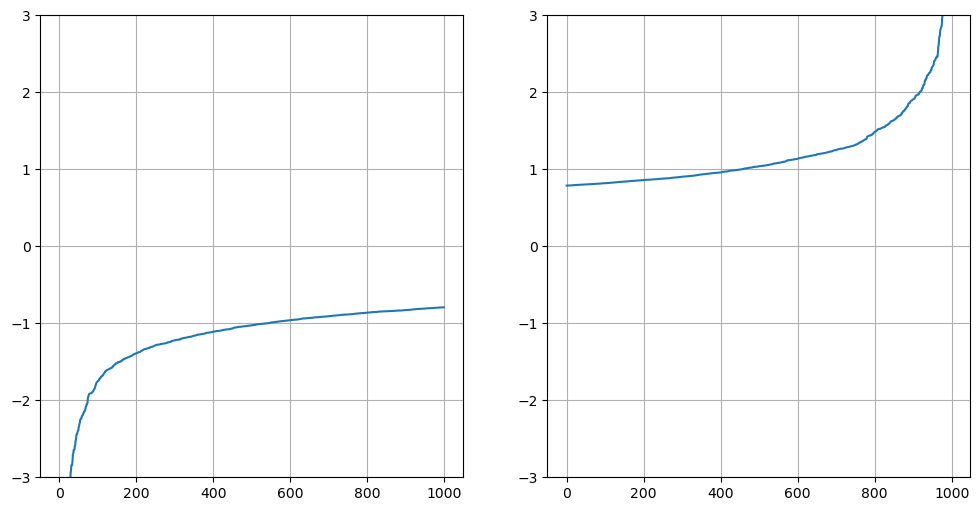

In [149]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
for i, rng in enumerate([(0, 1000), (-1000, -1)]):
    sns.lineplot(ll_np[rng[0]:rng[1]], ax=ax[i])
    ax[i].set_ybound(-3., 3.0)
    ax[i].grid(visible=True)
    print(f"{i}: {np.sum(ll_np[rng[0]:rng[1]])}")

In [87]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Params: {param.numel()}")

Layer: embedding.weight | Size: torch.Size([32, 9]) | Params: 288
Layer: embedding.bias | Size: torch.Size([32]) | Params: 32
Layer: attention.in_proj_weight | Size: torch.Size([96, 32]) | Params: 3072
Layer: attention.in_proj_bias | Size: torch.Size([96]) | Params: 96
Layer: attention.out_proj.weight | Size: torch.Size([32, 32]) | Params: 1024
Layer: attention.out_proj.bias | Size: torch.Size([32]) | Params: 32
Layer: fc.weight | Size: torch.Size([1, 3200]) | Params: 3200
Layer: fc.bias | Size: torch.Size([1]) | Params: 1


In [ ]:
# nan check
i = 0
for batch_data, batch_labels in dataloader: 
    for hz in THZ:
        if torch.isnan(batch_data[hz][0]).any() or torch.isinf(batch_data[hz][0]).any():
            print("NaN or Inf in inputs detected")
            i = 1; break
        if torch.isnan(batch_data[hz][1]).any() or torch.isinf(batch_data[hz][1]).any():
            print("NaN or Inf in labels detected")
            i = 1; break
            
    if i: break

### Test Area

In [89]:
hdf5_train = sc.StockDatasetHDF5(
    ticker_list=[
    'AAPL',  # Apple Inc.
],
    date_range=[ED-timedelta(weeks=4), ED]
)
hz_window = {k:v for k, v in zip(THZ,
                [5,1,1,1,1])}
hz_patch = {k:5 for k in THZ}
data_min_interval = timedelta(minutes=100)
label_peroid = 10
label_hz = '5m'
label_density = 1.0
batch_size = 64

dataset = StockDatasetIter(hdf5_train, hz_window, hz_patch, label_peroid, data_min_interval, label_hz, label_density,
                           Transforms.example, Transforms.yexample)
dataloader = DataLoader(dataset, batch_size=1)

In [91]:
data = hdf5_train[0]

In [94]:
x = Transforms.example(data, hz_patch)
for k in x.keys():
    print(x[k][0].shape)
y = Transforms.yexample(data[label_hz], label_peroid)
print(y.shape)
ym, yind = Transforms.get_ymask(data[label_hz], label_hz, hz_patch, label_peroid, data_min_interval, label_density)
print(ym.shape)
print(yind.shape)

torch.Size([7230, 6])
torch.Size([1446, 6])
torch.Size([241, 6])
torch.Size([19, 6])
torch.Size([5, 6])
torch.Size([1436])
(1446,)
(1446,)


In [95]:
x['1m'][0][:10]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8084, 1.0000, 0.7478, 0.7714, 2.0127],
        [0.2404, 1.0000, 0.0000, 0.0939, 0.0101, 0.5531],
        [1.0000, 0.0000, 0.0939, 0.0101, 0.6788, 0.6015],
        [0.0000, 0.1000, 0.0107, 0.7229, 1.0000, 0.5736],
        [0.0902, 0.0000, 0.7199, 1.0000, 0.9480, 0.5814],
        [0.0000, 0.7199, 1.0000, 0.9480, 0.0956, 0.5798]])

In [112]:
hdf5_train = sc.StockDatasetHDF5(
    ticker_list=[
    'AAPL',  # Apple Inc.
],
    date_range=[ED-timedelta(weeks=4), ED]
)
dataset = StockDatasetIter(hdf5_train, hz_window, hz_patch, label_peroid, data_min_interval, label_hz, label_density,
                           Transforms.example, Transforms.yexample)
dataloader = DataLoader(dataset, batch_size=1)
hdf5_train[0]['1m'].iloc[-105:-80]

ohlcv,open,high,low,close,volume,vwap,transactions
timestamp,,,,,,,
2024-12-13 14:15:00,247.6150,247.6900,247.6101,247.6650,36196.0,247.6623,553.0
2024-12-13 14:16:00,247.6700,247.7300,247.6700,247.7050,41415.0,247.7099,546.0
2024-12-13 14:17:00,247.7001,247.7050,247.6550,247.6850,25171.0,247.6805,470.0
2024-12-13 14:18:00,247.6800,247.7400,247.6500,247.7300,19880.0,247.6921,445.0
2024-12-13 14:19:00,247.7300,247.7500,247.6800,247.7281,33575.0,247.7123,558.0
2024-12-13 14:20:00,247.7250,247.7250,247.6400,247.6750,18083.0,247.6676,413.0
2024-12-13 14:21:00,247.6750,247.7400,247.6700,247.6900,20883.0,247.6947,422.0
2024-12-13 14:22:00,247.6950,247.7500,247.6900,247.7300,18607.0,247.7268,423.0
2024-12-13 14:23:00,247.7300,247.8299,247.7100,247.7850,30700.0,247.7717,477.0


---

In [117]:
samples = []
curidx = {hz:0 for hz in THZ}
for idx, yt in enumerate(tqdm(data[label_hz].index)):
    # ymask check
    if not ym[idx]: continue
    
    # curidx
    for hz in THZ:
        while True:
            if data[hz].index[curidx[hz]] + TO_TIMEDELTA[hz](1) - timedelta(minutes=1) > yt:
                break
            else: curidx[hz] += 1
    if curidx[label_hz] == 0: continue
    
    if not samples: 
        print(curidx)
        for hz in THZ:
            print(data[hz].index[curidx[hz]])
    
    # sample
    x_sample = [dict(), dict()]
    for hz in THZ:
        for rel in [0, 1]:
            x_st = curidx[hz] - hz_window[hz]
            if curidx[hz] == 0:
                # no data -> zeros
                x_sample[rel][hz] = torch.zeros((hz_window[hz], x[hz][rel].shape[1]))
                continue
            #
            if x_st < 0:
                # padding
                pad_size = (0, 0, -x_st, 0)
                x_sample[rel][hz] = nn.functional.pad(x[hz][rel][:curidx[hz]], pad_size, 'constant', 0)
            else:
                # slicing
                x_sample[rel][hz] = x[hz][rel][x_st:curidx[hz]]
            #
            if rel:
                # relative features
                flag = data[hz].iat[curidx[hz]-1, 3]
                x_sample[rel][hz] = torch.divide(x_sample[rel][hz] - flag, flag) * 100
                x_sample[rel][hz][x_sample[rel][hz] == -100] = 0

    # concat rel & non-rel
    temp = dict()
    for hz in THZ:
        temp[hz] = torch.cat([x_sample[0][hz], x_sample[1][hz]], dim=1)
        
    x_sample = temp
    y_sample = y[curidx[label_hz]-1]
    samples.append([x_sample, y_sample, curidx[label_hz]])
    

  0%|          | 0/416 [00:00<?, ?it/s]

 25%|██▍       | 102/416 [00:00<00:00, 1012.60it/s]

{'1m': 1951, '5m': 390, '30m': 65, '1d': 5, '1w': 1}
2015-01-09 09:31:00
2015-01-09 09:30:00
2015-01-09 09:30:00
2015-01-09 00:00:00
2015-01-05 00:00:00


100%|██████████| 416/416 [00:00<00:00, 772.59it/s] 


In [116]:
shape_set = {hz:set() for hz in THZ}
for sam in samples:
    temp = sam[0]
    for hz in THZ:
        shape_set[hz].add(temp[hz].shape)
    # if temp.shape == torch.Size([4, 9]): print(temp)
    
shape_set

{'1m': {torch.Size([3, 9])},
 '5m': {torch.Size([4, 9])},
 '30m': {torch.Size([5, 9])},
 '1d': {torch.Size([6, 9])},
 '1w': {torch.Size([7, 9])}}